In [3]:
from crystalbuilder import *
import crystalbuilder.geometry as geo
import matplotlib.pyplot as plt
import numpy as np
import vedo

This notebook will walk through an example of creating a 3D photonic crystal based on the rod-connected diamond motif. The structure will be made using CrystalBuilder's geo package and then simulated using MPB. 

First, let's define our basis. This will be a rhombohedral primitive basis. By convention, the diamond unit cell is actually cubic, so our lattice vector will be _sqrt(a/2)_ instead of _a_ units long

In [4]:
a1 = [0, 1, 1]
a2 = [1, 0 ,1]
a3 = [1, 1, 0]

a_mag = np.sqrt(.5)


geo_lattice = lattice.Lattice(a1, a2, a3, magnitude = [a_mag, a_mag, a_mag])

We've now defined our lattice. It's important to note that this is a CrystalBuilder lattice and not an MPB one. They can be converted, as we will show later, but they are not the exact same. 

Let's get the positions of the "atoms" in the diamond lattice that our rods will connect.

The square diamond lattice looks like 4 tetrahedra connected to one another, but our rhombohedral primitive cell will only include one of them. The tetrahedral rods will connect to one another at (1/4, 1/4, 1/4)*a.

The other points will be:
- (0,0,0)
- (1/2, 1/2, 0)*a
- (1/2, 0, 1/2)*a
- (0, 1/2, 1/2)*a


We'll make cylinders that connect these points. CrystalBuilder's Cylinder class features a way to define the objects based on their start/end positions and a radius. Let's set those now.

In [5]:
diamond_points = [
    (1/4, 1/4, 1/4),
    (0,0,0),
    (1/2, 1/2, 0),
    (1/2, 0, 1/2),
    (0,1/2, 1/2)
]


radius = .01*a_mag

cylinder_1 = geo.Cylinder.from_vertices([diamond_points[0], diamond_points[1]], radius=radius)
cylinder_2 = geo.Cylinder.from_vertices([diamond_points[0], diamond_points[2]], radius=radius)
cylinder_3 = geo.Cylinder.from_vertices([diamond_points[0], diamond_points[3]], radius=radius)
cylinder_4 = geo.Cylinder.from_vertices([diamond_points[0], diamond_points[4]], radius=radius)

unit_cell = [cylinder_1, cylinder_2, cylinder_3, cylinder_4]

Now lets use our previously defined lattice to tile these cylinders into a crystal.

In [6]:
a1_reps = 1
a2_reps = 2
a3_reps = 2
crystal = geo_lattice.tile_geogeometry(unit_cell, a1_reps, a2_reps, a3_reps, style="positive")

In [24]:
for n in crystal:
    print(n.center)

[np.float64(0.125), np.float64(0.125), np.float64(0.125)]
[np.float64(0.625), np.float64(0.625), np.float64(0.125)]
[np.float64(0.625), np.float64(0.125), np.float64(0.625)]
[np.float64(1.125), np.float64(0.625), np.float64(0.625)]
[np.float64(0.375), np.float64(0.375), np.float64(0.125)]
[np.float64(0.875), np.float64(0.875), np.float64(0.125)]
[np.float64(0.875), np.float64(0.375), np.float64(0.625)]
[np.float64(1.375), np.float64(0.875), np.float64(0.625)]
[np.float64(0.375), np.float64(0.125), np.float64(0.375)]
[np.float64(0.875), np.float64(0.625), np.float64(0.375)]
[np.float64(0.875), np.float64(0.125), np.float64(0.875)]
[np.float64(1.375), np.float64(0.625), np.float64(0.875)]
[np.float64(0.125), np.float64(0.375), np.float64(0.375)]
[np.float64(0.625), np.float64(0.875), np.float64(0.375)]
[np.float64(0.625), np.float64(0.375), np.float64(0.875)]
[np.float64(1.125), np.float64(0.875), np.float64(0.875)]


We can visualize this using CrystalBuilder's viewer package, which builds the structure as a Vedo scene. 

In [7]:
scene = viewer.visualize(crystal)
scene = viewer.visualize_unit_cell(geo_lattice, scene)
scene.show().close()

# objects = scene.get_meshes()

# k=0
# for obj in objects:
#     k+=1
#     string=f"diamond/object-{k}.obj"
#     vedo.write(obj, string)


vedo.transformations.LinearTransform at (0x2d33c221390)            
name          : LinearTransform
concatenations: 1
inverse flag  : False
matrix 4x4    :
[[0. , 0.5, 0.5, 0. ],
 [0.5, 0. , 0.5, 0. ],
 [0.5, 0.5, 0. , 0. ],
 [0. , 0. , 0. , 1. ]]
vedo.mesh.Mesh at (0x2d33c9e1b60)                                          
name          : MeshBoundaries
elements      : vertices=8 polygons=0 lines=24
position      : (0, 0, 0)
scaling       : (1.00000, 1.00000, 1.00000)
size          : average=0.591506, diagonal=1.73205
center of mass: (0.500000, 0.500000, 0.500000)
bounds        : x=(0, 1.00), y=(0, 1.00), z=(0, 1.00)
pointdata     : "Normals" (float32), dim=3


It looks good, so let's convert to MPB and simulate a band structure.

In [ ]:
import meep as mp
from meep import mpb

material = mp.Medium(epsilon=9)

mpb_lattice = convert.to_mpb_lattice(geo_lattice)
mpb_geometry = convert.geo_to_mpb(unit_cell, material=material, lattice=mpb_lattice)



The above conversions are done by the CrystalBuilder convert module, and our output defines our mpb_lattice and our mpb_geometry

We then define our k points and other simulation parameters like normal!

In [ ]:
vlist = [
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0, 0.625, 0.375),    # U
    mp.Vector3(0, 0.5, 0),          # L
    mp.Vector3(0, 0, 0),            # Gamma
    mp.Vector3(0, 0.5, 0.5),        # X
    mp.Vector3(0.25, 0.75, 0.5),    # W
    mp.Vector3(0.375, 0.75, 0.375)  # K
]
k_corners = len(vlist)
k_points = mp.interpolate(1, vlist)
tick_labs = ['X', 'U', 'L', '\Gamma','X', 'W', 'K']


resolution = 16  # use a 16x16x16 grid
mesh_size = 1
num_bands = 10

ms = mpb.ModeSolver(
    geometry_lattice=mpb_lattice,
    k_points=k_points,
    geometry=mpb_geometry,
    resolution=resolution,
    num_bands=num_bands,
    mesh_size=mesh_size
)

ms.run()

Initializing eigensolver data
Computing 10 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 16 x 16 x 16.
Solving for 10 bands at a time.
Creating Maxwell data...
Mesh size is 1.
Lattice vectors:
     (1, 0, 0)
     (0, 1, 0)
     (0, 0, 1)
Cell volume = 1
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 1, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0.75,0.75,0.75)
          radius 0.01, height 0.866025, axis (0.57735, 0.57735, 0.57735)
     cylinder, center = (0.5,0.5,0.75)
          radius 0.01, height 0.5, axis (0, 0, 1)
     cylinder, center = (0.5,0.75,0.5)
          radius 0.01, height 0.5, axis (0, 1, 0)
     cylinder, center = (0.75,0.5,0.5)
          radius 0.01, height 0.5, axis (1, 0, 0)
Geometric object tree has depth 4 and 32 object nodes (vs. 4 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: .
Initializing fields to random numbers...
13 k-points
  Vector3<0.0, 0.5, 0.5>

epsilon: 1-9, mean 1.21732, harm. mean 1.04101, 7.06019% > 1, 2.71653% "fill"


real part range: 1 .. 9


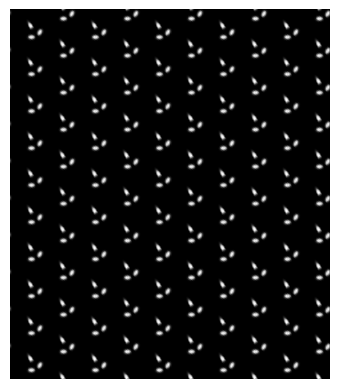

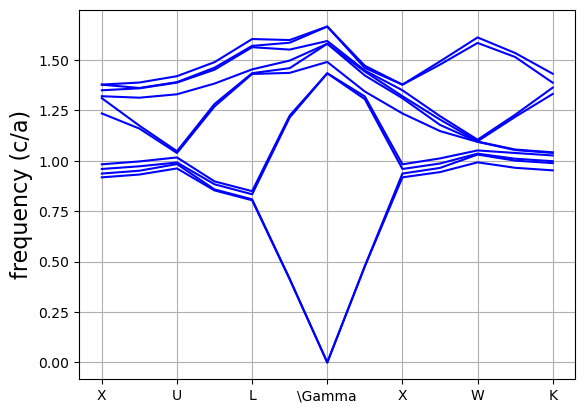

In [ ]:
### Plotting Dielectric Map ###
plt.figure()
md = mpb.MPBData(rectify=True, periods=7, resolution=64)
eps = ms.get_epsilon()
converted_eps = md.convert(eps)
layer_slice = 9
plt.imshow(converted_eps[:,:, layer_slice], interpolation='spline36', cmap='binary_r')
plt.axis('off')
plt.show()

### Plotting Band Structure ###
crysfreqs = ms.all_freqs
x = range(len(crysfreqs))
figgy = plt.figure()
plt.plot(x,crysfreqs, color='blue');
points_in_between = (len(crysfreqs)-1) / (k_corners-1)
tick_locs = [i*points_in_between for i in range(k_corners)]

plt.xticks(tick_locs,tick_labs)
plt.ylabel('frequency (c/a)', size=16)
plt.grid(True)
figax = plt.gca()

plt.show()


Output the structure to an array for rebuilding via marching_cubes.

In [ ]:
filename = "DiamondLattice_Rebuilt"

np.save(filename, converted_eps)